In [1]:
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch

random.seed(27)
np.random.seed(27)
plt.style.use('ggplot')

## Dataset

In [5]:
# Pick dataset
ds = "cifar10"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if ds == "cifar10":
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
    test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
elif ds == "mnist":
    train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    test_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [6]:
X_train = train_ds.data.astype(np.float32) / 255.0  # normalize manually
y_train = np.array(train_ds.targets, dtype=np.int64)

X_test  = test_ds.data.astype(np.float32) / 255.0
y_test  = np.array(test_ds.targets, dtype=np.int64)

X_train = X_train.reshape(X_train.shape[0], -1)
X_test  = X_test.reshape(X_test.shape[0], -1)


In [4]:

X_train = train_ds.data.to(torch.float32).numpy()
y_train = train_ds.targets.to(torch.int64).numpy()

X_test  = test_ds.data.to(torch.float32).numpy()
y_test  = test_ds.targets.to(torch.int64).numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [7]:
# Flatten
X_train = X_train.reshape(-1, np.prod(X_train.shape[1:]))
X_test = X_test.reshape(-1, np.prod(X_test.shape[1:]))

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (50000, 3072) (50000,)
Test shape: (10000, 3072) (10000,)


In [ ]:
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root="./data", train=False, download=True, transform=None)

X_train = mnist_train.data.to(torch.float32).numpy()
y_train = mnist_train.targets.to(torch.int64).numpy()

X_test  = mnist_test.data.to(torch.float32).numpy()
y_test  = mnist_test.targets.to(torch.int64).numpy()

In [ ]:
# Normalize the pixel values (important for neural nets)
X_train /= 255.0
X_test /= 255.0

# Flatten
X_train = X_train.reshape(-1, np.prod(X_train.shape[1:]))
X_test = X_test.reshape(-1, np.prod(X_test.shape[1:]))

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (60000, 784) (60000,)
Test shape: (10000, 784) (10000,)


In [8]:
def one_hot_encode(y, num_classes=10):
    y_encoded = np.zeros((num_classes, y.size))
    y_encoded[y, np.arange(y.size)] = 1
    return y_encoded

Y_train = one_hot_encode(y_train, 10)  # (10, 60000)
Y_test  = one_hot_encode(y_test, 10)   # (10, 10000)

# --------------------------------------------------
# Quick check
# --------------------------------------------------
print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test: ", X_test.shape,  "Y_test: ",  Y_test.shape)

X_train: (50000, 3072) Y_train: (10, 50000)
X_test:  (10000, 3072) Y_test:  (10, 10000)


## Feedforward Neural Network

General feed-forward networks have the following recurrence relation. Given input $\bm{x} \in \mathbb{R}^D$ and outputs $\bm{y} \in \mathbb{R}^K$:
$$
\bm{x} = \begin{bmatrix}
x_1 \\
x_2 \\
\vdots \\
x_D
\end{bmatrix}
, \qquad
\bm{y} = \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_K
\end{bmatrix}
$$
and layers $l = 1, 2, \dots, L$.

Furthermore we have activation functions $h_j(\cdot)$ to non-linearize the pre-activations so that they can perform smooth fits of points.

First layer:
$$
a_j^{(1)} = \sum^{D}_{i=1} w_{ji}^{(1)} x_i + w_{j0}^{(1)}, \qquad z_i^{(0)} = x_i
$$

Second layer:
$$
a_j^{(2)} = \sum^{M}_{i=1} w_{ji}^{(2)} z_i^{(1)} + w_{j0}^{(2)}
$$

$l$'th layer:
$$
a_j^{(l)} = \sum_{i=1} w_{ji}^{(l)} z_i^{(l-1)} + w_{j0}^{(l)}
$$

Final layer (output):
$$
y_j = z_j^{(L)} = h_L(a_j^{(L)})
$$

Note here that all $a_j^{(\ell)}$ are known as pre-activations and $z_j^{(\ell)}$ are known as post-activations.

All of this can also be written in vector/matrix notation, which is the kind that we will use in this project (since the vectorization of operations is more efficient):
$$
\bm{X} =
\begin{bmatrix}
\vert & \vert & & \vert\\
\bm{x}^{(1)} & \bm{x}^{(2)} & \dots & \bm{x}^{(m)} \\
\vert & \vert & & \vert
\end{bmatrix} \in \mathbb{R}^{D \times m}
$$
where $m$ is number of samples and $D$ is number of features.

For a network with $L$ layers $l = 1, 2, \dots, L$, we have:
$$
\bm{A}^{(l)} = \bm{W}^{(l)} \bm{Z}^{(l-1)} + \bm{b}^{(l)}, \quad \bm{Z}^{(l)} = h^{(l)}(\bm{A}^{(l)}), \quad \bm{Z}^{(0)} = \bm{X}, \quad \bm{Y}_{\text{pred}} = \bm{Z}^{(L)}
$$

where the bias vector $\bm{b}^{(l)}$ is broadcast across all $m$ samples.

### Activation functions

Activation functions must support both forward and backward propagation for a layer. Forward propagation simply uses the base function (non-derivative). Backward propagation uses the first order derivative of the function itself.

In [9]:
class Activation:
    def forward(self, Z):
        raise NotImplementedError
    def backward(self, dA, Z):
        raise NotImplementedError

class ReLU:
    def forward(self, Z):
        self.Z = Z
        return np.maximum(0, Z)
    
    def backward(self, dA):
        return dA * (self.Z > 0).astype(float)

class Sigmoid:
    def forward(self, Z):
        self.Z = Z
        self.A = 1 / (1 + np.exp(-Z))
        return self.A
    
    def backward(self, dA):
        return dA * self.A * (1 - self.A)

class Tanh:
    def forward(self, Z):
        self.Z = Z
        self.A = np.tanh(Z)
        return self.A
    
    def backward(self, dA):
        return dA * (1 - self.A**2)

class Identity:
    def forward(self, Z):
        self.Z = Z
        return Z
    
    def backward(self, dA):
        return dA

class Softmax:
    def forward(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        self.A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
        return self.A
    
    def backward(self, dA):
        # Usually handled with cross-entropy; raise if used alone
        raise NotImplementedError("Softmax derivative should be combined with cross-entropy.")


In [10]:
# Activation functions
def relu(x, derivative:bool=False):
    if not derivative:
        return np.maximum(x, 0)
    else:
        return np.where(x > 0, 1, 0)
    
def sigmoid(x, derivative:bool=False):
    t = 1 / (1.0 + np.exp(-x))
    if not derivative:
        return t
    else:
        return t * (1 - t)

# Prediction function
def softmax(x, derivative=False, batch=True):
    if batch:   # x: (n_classes, batch)
        exp_x = np.exp(x - np.max(x, axis=0, keepdims=True))
        out = exp_x / np.sum(exp_x, axis=0, keepdims=True)
    else:       # x: (batch, n_classes)
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        out = exp_x / np.sum(exp_x, axis=1, keepdims=True)

    if not derivative:
        return out
    else:
        # Softmax derivative is handled via cross-entropy shortcut
        raise NotImplementedError("Use dZ = softmax - one_hot_labels for CE loss.")

### Initializer

A function/class to initialize weights $w_{ji}^{(l)} \equiv \bm{W}^{(l)}$ and bias $w_{j0}^{(l)} \equiv \bm{b}^{(l)}$ for each layer $l$.

In [11]:
class Initializer:
    """Base class for all weight initializers."""
    def init_weights(self, n_in, n_out):
        raise NotImplementedError

    def init_bias(self, n_out):
        raise NotImplementedError

class ConstantInitializer(Initializer):
    def __init__(self, weight=1.0, bias=0.0):
        self.weight = weight
        self.bias = bias

    def init_weights(self, n_in, n_out):
        return np.full((n_in, n_out), self.weight)

    def init_bias(self, n_out):
        return np.full((n_out,), self.bias)

class NormalInitializer(Initializer):
    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std
    
    def init_weights(self, n_in, n_out):
        return np.random.normal(self.mean, self.std, (n_out, n_in))
    
    def init_bias(self, n_out):
        return np.zeros((n_out, 1))

class HeInitializer(Initializer):
    def init_weights(self, n_in, n_out):
        std = np.sqrt(2 / n_in)
        return np.random.randn(n_out, n_in) * std
    
    def init_bias(self, n_out):
        return np.zeros((n_out, 1))

### Layers

We now construct a layer class to handle all forward and backward propagation.

In [12]:
class Layer:
    def forward(self, A_prev): # A^[l-1]
        raise NotImplementedError

    def backward(self, dA, learning_rate): # dA^[l]
        raise NotImplementedError

class DenseLayer(Layer):
    def __init__(
        self,
        n_in:int,
        n_out:int,
        activation:Activation,
        initializer:Initializer=None,
        l2_coeff:float=0.0
    ):
        # Initialize weights and bias
        self.initializer = initializer #or HeInitializer()
        self.W = self.initializer.init_weights(n_in, n_out) # W
        self.b = self.initializer.init_bias(n_out)          # b
        self.activation = activation
        self.l2_coeff = l2_coeff

        # Caching during forward/backward
        self.Z = None
        self.A_prev = None

    #def __repr__(self):    
    #    return 'Weights: ' + repr(self.W.shape) + ' Biases: ' + repr(self.b.shape)
    
    def __repr__(self):
        act_name = self.activation.__class__.__name__
        return (
            f"DenseLayer({self.W.shape[1]} -> {self.W.shape[0]}, Activation={act_name})\n"
            f"Weights shape: {self.W.shape}, min: {self.W.min():.4f}, max: {self.W.max():.4f}, mean: {self.W.mean():.4f}\n"
            f"Biases shape: {self.b.shape}, min: {self.b.min():.4f}, max: {self.b.max():.4f}, mean: {self.b.mean():.4f}"
        )
    
    def forward(self, A_prev):
        # Save for backward
        self.A_prev = A_prev                     # (n_in, m)
        self.Z = np.dot(self.W, A_prev) + self.b # (n_out, m)

        # Return activation
        return self.activation.forward(self.Z)
    
    def backward(self, dA):
        m = self.A_prev.shape[1] # batch size

        if isinstance(self.activation, Softmax):
            dZ = dA
        else:
            dZ = self.activation.backward(dA)

        # Gradients
        dW = (1/m) * np.dot(dZ, self.A_prev.T) + (self.l2_coeff/m) * self.W
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        
        # Gradient for previous layer
        dA_prev = np.dot(self.W.T, dZ)
        
        return dA_prev, dW, db

Quick test, probability distribution:

In [13]:
layer1 = DenseLayer(
    n_in=X_train.shape[1],
    n_out=15,
    activation=ReLU(),
    initializer=HeInitializer()
)
output_layer = DenseLayer(
    n_in=15,
    n_out=10,
    activation=Softmax(),
    initializer=NormalInitializer()
)

A1 = layer1.forward(X_train.T)      # ReLU
A2 = output_layer.forward(layer1.Z) # SoftMax

sample_probs = A2[:, 0]      # first sample
print(sample_probs)
print(sum(sample_probs))     # should be 1.0


[0.10721766 0.05868561 0.13759114 0.08302101 0.10594911 0.09281751
 0.10444769 0.12927335 0.08861086 0.09238604]
1.0


In [14]:
print(layer1)

DenseLayer(3072 -> 15, Activation=ReLU)
Weights shape: (15, 3072), min: -0.1006, max: 0.1095, mean: 0.0000
Biases shape: (15, 1), min: 0.0000, max: 0.0000, mean: 0.0000


### Loss

Loss functions

In [15]:
class Loss:
    def forward(self, A, Y):
        raise NotImplementedError
    
    def backward(self, A, Y):
        raise NotImplementedError

class CrossEntropyLoss(Loss):
    def forward(self, A, Y):
        m = Y.shape[1]
        loss = -np.sum(Y * np.log(A + 1e-8)) / m
        return loss
    
    def backward(self, A, Y):
        return A - Y  # derivative when combined with softmax

class MSELoss(Loss):
    def forward(self, A, Y):
        m = Y.shape[1]
        return np.sum((A - Y)**2) / (2 * m)
    
    def backward(self, A, Y):
        m = Y.shape[1]
        return (A - Y) / m

### Optimizer

In [16]:
class Optimizer:
    def update(self, layer, dW, db):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, learning_rate=0.01):
        self.lr = learning_rate
    
    def update(self, layer, dW, db):
        layer.W -= self.lr * dW
        layer.b -= self.lr * db

class Adam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.t = 0
        self.m = {}  # momentum
        self.v = {}  # RMSprop
    
    def update(self, layer, dW, db):
        if layer not in self.m:
            # Initialize moments
            self.m[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}
            self.v[layer] = {'dW': np.zeros_like(dW), 'db': np.zeros_like(db)}
        
        self.t += 1
        # Momentum
        self.m[layer]['dW'] = self.beta1 * self.m[layer]['dW'] + (1 - self.beta1) * dW
        self.m[layer]['db'] = self.beta1 * self.m[layer]['db'] + (1 - self.beta1) * db
        # RMS
        self.v[layer]['dW'] = self.beta2 * self.v[layer]['dW'] + (1 - self.beta2) * (dW**2)
        self.v[layer]['db'] = self.beta2 * self.v[layer]['db'] + (1 - self.beta2) * (db**2)
        # Bias-corrected
        m_hat_W = self.m[layer]['dW'] / (1 - self.beta1**self.t)
        m_hat_b = self.m[layer]['db'] / (1 - self.beta1**self.t)
        v_hat_W = self.v[layer]['dW'] / (1 - self.beta2**self.t)
        v_hat_b = self.v[layer]['db'] / (1 - self.beta2**self.t)
        # Update
        layer.W -= self.lr * m_hat_W / (np.sqrt(v_hat_W) + self.eps)
        layer.b -= self.lr * m_hat_b / (np.sqrt(v_hat_b) + self.eps)

### Network

Forward pass:

In [17]:
NN = [
    DenseLayer(X_train.shape[1], 15, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(15, 10, activation=Softmax(), initializer=NormalInitializer())
]

def forward(input, network):
    x = input.T  # transpose: (features, batch)
    for layer in network:
        x = layer.forward(x)
    return x

print(forward(X_train, NN))

[[0.09441302 0.09152761 0.08505437 ... 0.08973359 0.08486975 0.08320156]
 [0.09810909 0.09902408 0.10594231 ... 0.10332246 0.09644671 0.10605516]
 [0.12338633 0.12368793 0.14759088 ... 0.13019119 0.14322895 0.1312139 ]
 ...
 [0.08585535 0.08107811 0.07830358 ... 0.08360684 0.08193105 0.08790131]
 [0.09351692 0.09726102 0.08536529 ... 0.0880282  0.09322982 0.09260585]
 [0.1056849  0.10352732 0.11181221 ... 0.11314312 0.10973245 0.12239055]]


Backward pass:

In [18]:
NN = [
    DenseLayer(X_train.shape[1], 15, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(15, 10, activation=Softmax(), initializer=NormalInitializer())
]

output = forward(X_train, NN)

loss_fn = CrossEntropyLoss()
dA = loss_fn.backward(A=output, Y=Y_train)

dA

array([[ 0.11149089,  0.11523794,  0.15468617, ...,  0.10693218,
         0.13798906,  0.12598122],
       [ 0.09588186,  0.09355614,  0.07934079, ...,  0.0930462 ,
        -0.91693222, -0.90841857],
       [ 0.09058594,  0.07610803,  0.07901871, ...,  0.073122  ,
         0.07084708,  0.07623192],
       ...,
       [ 0.10442361,  0.11898564,  0.1116311 , ...,  0.12306351,
         0.12090854,  0.11764786],
       [ 0.09304902,  0.0881423 ,  0.08481642, ...,  0.08602494,
         0.08100923,  0.08764436],
       [ 0.09424447, -0.90132535, -0.91329183, ..., -0.89742342,
         0.09612978,  0.09454409]], shape=(10, 50000))

In [19]:
[print('Layer', i, '\n', NN[i]) for i in range(len(NN))] 

Layer 0 
 DenseLayer(3072 -> 15, Activation=ReLU)
Weights shape: (15, 3072), min: -0.1013, max: 0.1107, mean: -0.0001
Biases shape: (15, 1), min: 0.0000, max: 0.0000, mean: 0.0000
Layer 1 
 DenseLayer(15 -> 10, Activation=Softmax)
Weights shape: (10, 15), min: -0.2730, max: 0.2904, mean: 0.0006
Biases shape: (10, 1), min: 0.0000, max: 0.0000, mean: 0.0000


[None, None]

### Train

In [20]:
def train(X, Y, layers, loss_fn, optimizer, epochs=5, batch_size=64):
    m = X.shape[0]
    for epoch in range(epochs):
        perm = np.random.permutation(m)
        X_shuffled = X[perm].T  # shape: (features, batch)
        Y_shuffled = Y[:, perm] # shape: (classes, batch)

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]

            # Forward
            A = X_batch
            for layer in layers:
                A = layer.forward(A)

            # Compute loss
            loss = loss_fn.forward(A, Y_batch)

            # Backward
            dA = loss_fn.backward(A, Y_batch)
            for layer in reversed(layers):
                dA, dW, db = layer.backward(dA)
                optimizer.update(layer, dW, db)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

In [ ]:
# Define network
layers = [
    DenseLayer(X_train.shape[1], 128, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(128, 10, activation=Softmax(), initializer=NormalInitializer(mean=0, std=0.01))
]

# Optimizer
opt = SGD(learning_rate=0.1)

# Train
train(X_train, Y_train, layers, CrossEntropyLoss(), opt, epochs=5, batch_size=128)

Epoch 1/5, Loss: 1.7520
Epoch 2/5, Loss: 2.1333
Epoch 3/5, Loss: 1.6560
Epoch 4/5, Loss: 1.7894
Epoch 5/5, Loss: 1.6696


Epoch 1/100 | Loss: 2.2994 | Acc: 0.2839
Epoch 2/100 | Loss: 2.4032 | Acc: 0.3149
Epoch 3/100 | Loss: 1.7611 | Acc: 0.3234
Epoch 4/100 | Loss: 1.8875 | Acc: 0.3506
Epoch 5/100 | Loss: 1.8031 | Acc: 0.3563
Epoch 6/100 | Loss: 1.6116 | Acc: 0.3750
Epoch 7/100 | Loss: 1.9424 | Acc: 0.3686
Epoch 8/100 | Loss: 2.0644 | Acc: 0.3934
Epoch 9/100 | Loss: 1.5145 | Acc: 0.3953
Epoch 10/100 | Loss: 1.6326 | Acc: 0.4065
Epoch 11/100 | Loss: 1.4210 | Acc: 0.3918
Epoch 12/100 | Loss: 1.8595 | Acc: 0.4069
Epoch 13/100 | Loss: 1.6650 | Acc: 0.4125
Epoch 14/100 | Loss: 1.8437 | Acc: 0.4211
Epoch 15/100 | Loss: 1.9773 | Acc: 0.3890
Epoch 16/100 | Loss: 1.4426 | Acc: 0.4026
Epoch 17/100 | Loss: 1.6726 | Acc: 0.4390
Epoch 18/100 | Loss: 0.9303 | Acc: 0.4228
Epoch 19/100 | Loss: 1.6621 | Acc: 0.4358
Epoch 20/100 | Loss: 1.1289 | Acc: 0.4384
Epoch 21/100 | Loss: 1.8672 | Acc: 0.4300
Epoch 22/100 | Loss: 1.6810 | Acc: 0.4271
Epoch 23/100 | Loss: 1.6256 | Acc: 0.4257
Epoch 24/100 | Loss: 1.6107 | Acc: 0.4400
E

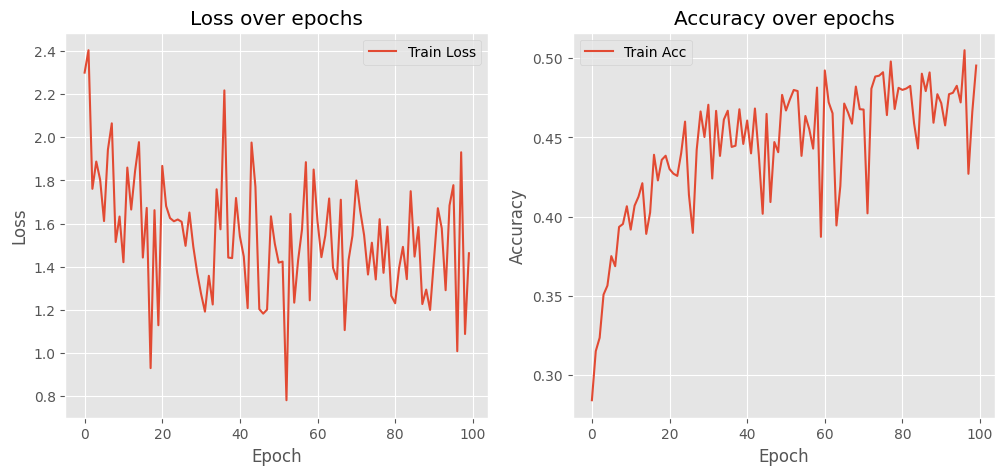

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Accuracy function
# ----------------------------
def compute_accuracy(layers, X, Y_true):
    A = X.T  # shape (features, batch)
    for layer in layers:
        A = layer.forward(A)
    y_pred = np.argmax(A, axis=0)
    y_true = np.argmax(Y_true, axis=0)
    acc = np.mean(y_pred == y_true)
    return acc

# ----------------------------
# Modified training loop
# ----------------------------
def train_plot(X, Y, layers, loss_fn, optimizer, epochs=5, batch_size=64, X_val=None, Y_val=None):
    m = X.shape[0]
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    for epoch in range(epochs):
        perm = np.random.permutation(m)
        X_shuffled = X[perm].T  # (features, batch)
        Y_shuffled = Y[:, perm]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]

            # Forward pass
            A = X_batch
            for layer in layers:
                A = layer.forward(A)

            # Compute loss
            loss = loss_fn.forward(A, Y_batch)

            # Backward pass
            dA = loss_fn.backward(A, Y_batch)
            for layer in reversed(layers):
                dA, dW, db = layer.backward(dA)
                optimizer.update(layer, dW, db)

        # Record metrics at the end of the epoch
        train_acc = compute_accuracy(layers, X, Y)
        history['loss'].append(loss)
        history['accuracy'].append(train_acc)

        if X_val is not None and Y_val is not None:
            # Validation metrics
            val_loss = loss_fn.forward(forward_pass(X_val.T, layers), Y_val)
            val_acc = compute_accuracy(layers, X_val, Y_val)
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_acc)
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Acc: {train_acc:.4f}")

    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history['loss'], label='Train Loss')
    if X_val is not None:
        plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1,2,2)
    plt.plot(history['accuracy'], label='Train Acc')
    if X_val is not None:
        plt.plot(history['val_accuracy'], label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.show()

    return history

# ----------------------------
# Helper: forward pass
# ----------------------------
def forward_pass(X_T, layers):
    A = X_T
    for layer in layers:
        A = layer.forward(A)
    return A

# ----------------------------
# Example usage
# ----------------------------

# Define network
layers = [
    DenseLayer(X_train.shape[1], 20, activation=ReLU(), initializer=HeInitializer()),
    DenseLayer(20, 10, activation=Softmax(), initializer=NormalInitializer(mean=0, std=0.01))
]

# Optimizer
opt = SGD()

# Train and plot
history = train_plot(X_train, Y_train, layers, CrossEntropyLoss(), opt, epochs=100, batch_size=64)